In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import osz

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "data_msg_type/"
X_path = dataset_path + "semantic_sim.txt"
y_path = dataset_path + "semantic_label_index.txt"

X = load_X(X_path)
y = load_y(y_path)
x = X.reshape(len(X), 1, 10, 14)

# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_y.shape)

Separating data into 80% training set & 20% test set...
Dataset separated.

((80000, 1, 10, 14), (80000, 14), (20000, 14))


# define parameters

In [5]:
input_height = 1
input_width = 10
num_channels = 14
num_labels = 14  

batch_size = 100
kernel_size = 4
depth = 35
num_hidden = 1000

learning_rate = 0.0001
# iteration times
training_epochs = 120

total_batches = train_x.shape[0] // batch_size

# network config

In [6]:
# init nn parameters
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

# conv
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

# build network

In [7]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,2,1)
c = apply_depthwise_conv(p,5,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

# loss func
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_history = np.empty(shape=[1], dtype=float)

# train and test

In [8]:
with tf.Session(config=sess_config) as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        for b in range(total_batches):    
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print "Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ", \
          session.run(accuracy, feed_dict={X: train_x, Y: train_y})
    y_pred = tf.argmax(y_, 1)
    y_true = np.argmax(test_y, 1)
    final_acc, y_pred = session.run([accuracy, y_pred], feed_dict={X: test_x, Y: test_y})
    print "Testing Accuracy: {}".format(final_acc)
    print()
    
    # model metrics
    temp_y_true = np.unique(y_true)
    temp_y_pred = np.unique(y_pred) 
    np.save("data/y_true", y_true) 
    np.save("data/y_pred", y_pred) 
    print "temp_y_true", temp_y_true 
    print "temp_y_pred", temp_y_pred
    
    print(classification_report(y_true, y_pred, 
                                target_names = fault_label.values()))
    print("confusion_matrix: ")
    print confusion_matrix(y_true, y_pred)

Epoch:  0  Training Loss:  192.584  Training Accuracy:  0.628287
Epoch:  1  Training Loss:  183.273  Training Accuracy:  0.630525
Epoch:  2  Training Loss:  142.612  Training Accuracy:  0.755924
Epoch:  3  Training Loss:  122.733  Training Accuracy:  0.758237
Epoch:  4  Training Loss:  113.436  Training Accuracy:  0.759862
Epoch:  5  Training Loss:  106.22  Training Accuracy:  0.767849
Epoch:  6  Training Loss:  100.113  Training Accuracy:  0.768237
Epoch:  7  Training Loss:  95.2009  Training Accuracy:  0.768474
Epoch:  8  Training Loss:  91.503  Training Accuracy:  0.774287
Epoch:  9  Training Loss:  87.1477  Training Accuracy:  0.780474
Epoch:  10  Training Loss:  88.1942  Training Accuracy:  0.780762
Epoch:  11  Training Loss:  85.4315  Training Accuracy:  0.787999
Epoch:  12  Training Loss:  81.5745  Training Accuracy:  0.788737
Epoch:  13  Training Loss:  81.5915  Training Accuracy:  0.789324
Epoch:  14  Training Loss:  78.807  Training Accuracy:  0.787049
Epoch:  15  Training Lo

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# confusion matrix

               precision    recall  f1-score   support

     security       1.00      0.19      0.33        36
       others       0.83      0.87      0.85      1815
    processor       1.00      0.94      0.97       506
         disk       0.00      0.00      0.00         1
      network       0.97      0.91      0.94      2429
         file       0.87      0.85      0.86       961
     database       0.99      1.00      0.99     12456
      service       0.87      0.69      0.77       595
       memory       0.74      0.99      0.85       422
communication       0.00      0.00      0.00        29
       system       0.00      0.00      0.00        25
       driver       0.80      0.92      0.86       721
           io       0.00      0.00      0.00         4

  avg / total       0.95      0.95      0.95     20000

[[    7     4     0     0     0     5     0     0     3     0     0    17
      0]
 [    0  1573     0     0    30    68    28    36    30     0     0    50
      0]
 [    

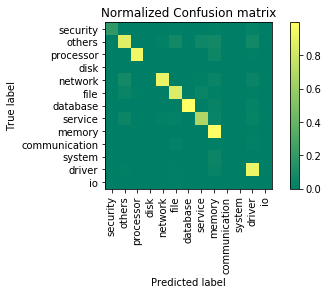

In [12]:
def plot_confusion_matrix(cm, title='Normalized Confusion matrix', 
                          cmap=plt.cm.get_cmap("summer")): 
    cm = cm / cm.astype(np.float).sum(axis=1) 
    #print "confusion_matrix: \n{}".format(cm) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    plt.colorbar() 
    tick_marks =np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90) 
    plt.yticks(tick_marks, fault_label.values()) 
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    plt.show()

def test_(): 
    y_true = np.load("data/y_true.npy") 
    y_pred = np.load("data/y_pred.npy") 
    print(classification_report(y_true, y_pred, 
          target_names = fault_label.values()))
    print(confusion_matrix(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred))

if __name__ == "__main__":
    test_()